
===== Cycle 1 / 2 =====


<Figure size 1000x700 with 0 Axes>

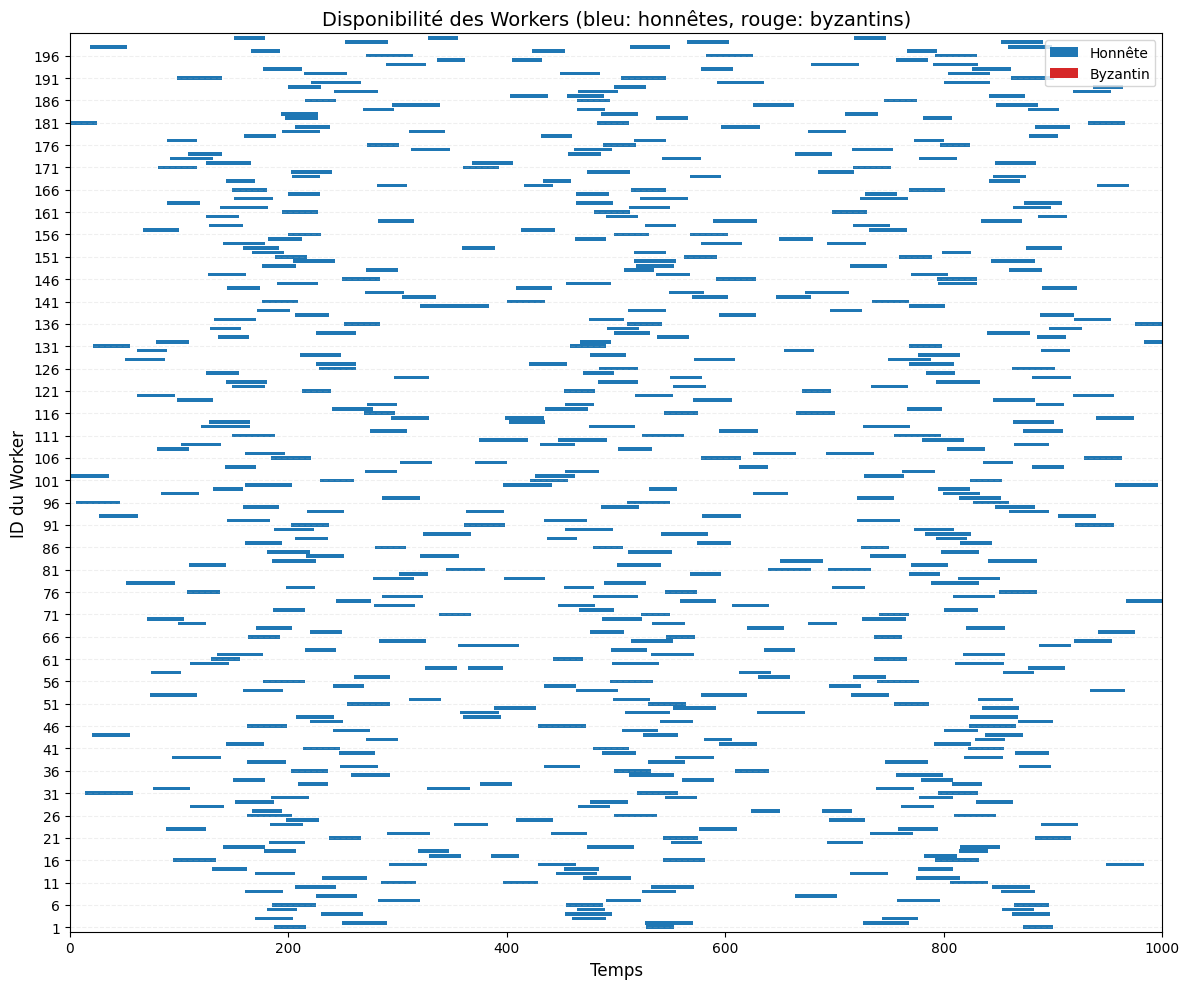

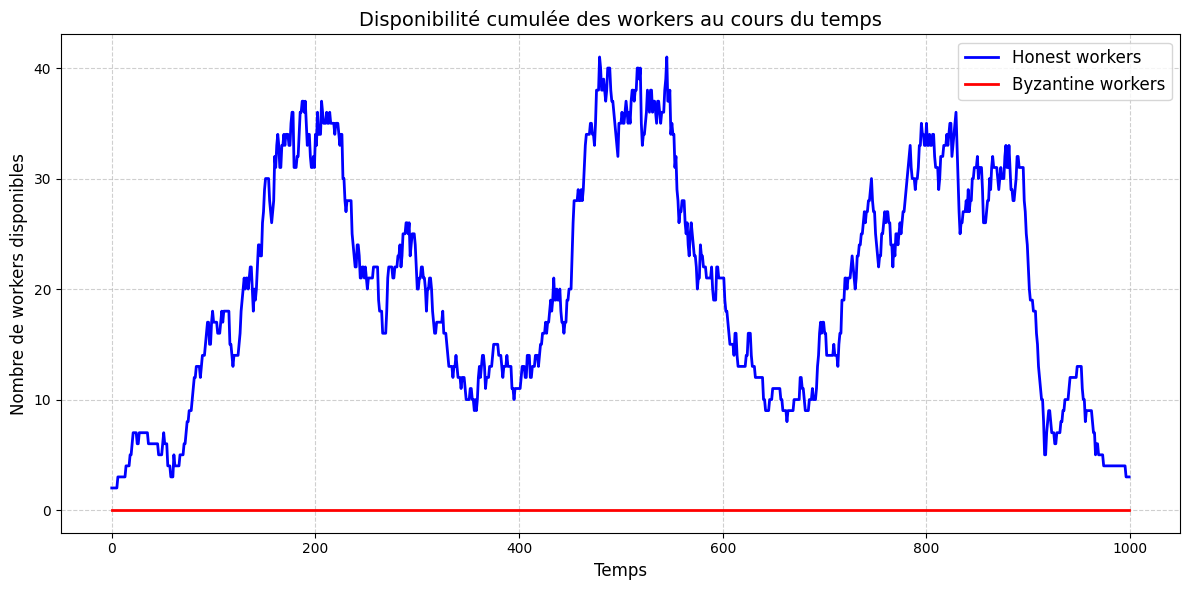

SafePoint initial - Accuracy: 8.42%
Temps (59) Full batch 1 traité — Performance = 14.45%
Temps (95) Full batch 2 traité — Performance = 42.97%
Temps (114) Full batch 3 traité — Performance = 57.86%
Mises à jour du groupe acceptées. Nouveau safe point établi.
Temps (134) Full batch 4 traité — Performance = 65.28%
Temps (146) Full batch 5 traité — Performance = 66.45%
Temps (155) Full batch 6 traité — Performance = 77.74%
Mises à jour du groupe acceptées. Nouveau safe point établi.


KeyboardInterrupt: 

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
import random
import numpy as np
import matplotlib.pyplot as plt
import byzfl
import torch.nn.functional as F
import copy

# ------------------------------------------------------------------------------
# Fonctions utilitaires (inchangées)
def merge_intervals(intervals):
    if not intervals:
        return []
    intervals.sort()
    merged = [intervals[0]]
    for current in intervals[1:]:
        last = merged[-1]
        if current[0] <= last[1]:
            merged[-1] = (last[0], max(last[1], current[1]))
        else:
            merged.append(current)
    return merged

def generate_gaussian_availability(total_time_steps, worker_id, num_workers,
                                   std_dev_ratio=0.08, min_processing_time=3,
                                   smoothing_window=10):
    """
    - Moins de pics (3 max), chacun avec intensité fixe = 1
    - Durées plus longues (3–5 × min_processing_time)
    - Après fusion, on dilate (smoothing_window) pour lisser les petits trous
    """
    peak_means = [0.2, 0.5, 0.8]
    std_dev = int(std_dev_ratio * total_time_steps)
    availability_periods = []
    for mean_ratio in peak_means:
        mean = int(mean_ratio * total_time_steps)
        # on fixe une seule intensité
        start_time = int(np.random.normal(loc=mean, scale=std_dev))
        start_time = max(0, min(start_time, total_time_steps - min_processing_time*3))
        # durée plus longue
        duration = random.randint(min_processing_time*3,
                                  min(min_processing_time*5, total_time_steps - start_time))
        end_time = start_time + duration
        availability_periods.append((start_time, end_time))

    # fusion des intervalles
    merged = merge_intervals(availability_periods)

    # dilation (smoothing) : on élargit chaque intervalle de +/- smoothing_window
    smoothed = []
    for s, e in merged:
        s2 = max(0, s - smoothing_window)
        e2 = min(total_time_steps, e + smoothing_window)
        smoothed.append((s2, e2))

    return merge_intervals(smoothed)


def generate_gaussian_byzantine_availability(
    total_time_steps, worker_id, num_workers,
    std_dev_ratio=0.05, min_processing_time=3,
    smoothing_window=10  # beaucoup plus large pour combler les trous
):
    off_peak_means = [0.1, 0.9]
    std_dev = int(std_dev_ratio * total_time_steps)
    availability_periods = []
    for mean_ratio in off_peak_means:
        mean = int(mean_ratio * total_time_steps)
        start = int(np.random.normal(loc=mean, scale=std_dev))
        start = max(0, min(start, total_time_steps - min_processing_time*4))
        # on force des durées très longues
        duration = random.randint(
            min_processing_time*4,
            min(min_processing_time*8, total_time_steps - start)
        )
        availability_periods.append((start, start + duration))

    # fusion + dilution (lissage)
    merged = merge_intervals(availability_periods)
    smoothed = []
    for s, e in merged:
        s2 = max(0, s - smoothing_window)
        e2 = min(total_time_steps, e + smoothing_window)
        smoothed.append((s2, e2))

    return merge_intervals(smoothed)

# ------------------------------------------------------------------------------
# Modèle
class LeNetLike(nn.Module):
    def __init__(self):
        super(LeNetLike, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64*7*7, 128)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64*7*7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# ------------------------------------------------------------------------------
# Gestionnaire de batch
class BatchManager:
    def __init__(self, dataset, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indices = list(range(len(dataset)))
        random.shuffle(self.indices)
        self.sampler = SubsetRandomSampler(self.indices)
        self.loader = iter(DataLoader(self.dataset, batch_size=self.batch_size, sampler=self.sampler))
    def get_next_batch(self):
        try:
            return next(self.loader)
        except StopIteration:
            random.shuffle(self.indices)
            self.sampler = SubsetRandomSampler(self.indices)
            self.loader = iter(DataLoader(self.dataset, batch_size=self.batch_size, sampler=self.sampler))
            return next(self.loader)

# ------------------------------------------------------------------------------
# Workers
class Worker:
    def __init__(self, model, device, worker_id, availability_periods, processing_time):
        self.is_byzantine = False  # Worker honnête par défaut
        self.device = device
        self.worker_id = worker_id
        self.availability_periods = availability_periods
        self.processing_time = processing_time
        self.model = model.to(device)
        self.criterion = nn.CrossEntropyLoss()
        self.finish_time = None
        self.current_batch_info = None  # (batch_id, mini_batch_idx)
    def is_available(self, current_time):
        for start, end in self.availability_periods:
            if start <= current_time < end:
                if self.finish_time is None or current_time >= self.finish_time:
                    return (current_time + self.processing_time) <= end
        return False
    def start_computation(self, current_time, batch_info, data, targets):
        if self.current_batch_info is None or self.current_batch_info != batch_info:
            self.current_batch_info = batch_info
            self.finish_time = current_time + self.processing_time
            return self.compute_gradient(data, targets)
        return None
    def has_finished(self, current_time):
        return self.finish_time == current_time
    def compute_gradient(self, data, targets):
        data, targets = data.to(self.device), targets.to(self.device)
        self.model.zero_grad()
        outputs = self.model(data)
        loss = self.criterion(outputs, targets)
        loss.backward()
        gradients = {name: param.grad.detach().clone() for name, param in self.model.named_parameters()}
        return gradients, self.current_batch_info
    def update_model(self, model_state_dict):
        self.model.load_state_dict(model_state_dict)

class ByzantineWorker(Worker):
    def __init__(self, model, device, worker_id, availability_periods, processing_time):
        super().__init__(model, device, worker_id, availability_periods, processing_time)
        self.is_byzantine = True
    def compute_gradient(self, data, targets):
        corrupted_gradients = {}
        for name, param in self.model.named_parameters():
            corrupted_gradients[name] = torch.full_like(param, 1e6)
        return corrupted_gradients, self.current_batch_info

# ------------------------------------------------------------------------------
# Server
class Server:
    def __init__(self, dataset, batch_size=64, mini_batch_size=16, lr=0.005, verbose=False,
                 aggregation_strategy='trimmed_mean', f=0, preagg=None):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = LeNetLike().to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.batch_manager = BatchManager(dataset, batch_size)
        self.mini_batch_size = mini_batch_size
        self.current_complete_batch = None
        self.current_batch_id = 0
        self.received_gradients = {}  # mini_idx -> gradient ou liste jusqu'au vote
        self.verbose = verbose
        self.aggregation_strategy = aggregation_strategy
        self.f = f
        self.preagg = preagg
        self.update_count = 0
        self.total_raw_compute_time = 0
        self.total_useful_compute_time = 0
        self.total_waste_compute_time = 0
        # Accumulateur de temps utile pour le full batch courant (issu des contributions gagnantes)
        self.current_full_batch_compute_time = 0

    def get_new_complete_batch(self, current_time):
        data, targets = self.batch_manager.get_next_batch()
        self.current_complete_batch = (data, targets)
        self.current_batch_id += 1
        # Réinitialiser l'accumulateur du full batch courant
        self.current_full_batch_compute_time = 0
        mini_batches = []
        num_samples = data.size(0)
        for i in range(0, num_samples, self.mini_batch_size):
            mini_data = data[i : i+self.mini_batch_size]
            mini_targets = targets[i : i+self.mini_batch_size]
            mini_batches.append((mini_data, mini_targets))
        self.current_mini_batches = {i: mini_batches[i] for i in range(len(mini_batches))}
        self.received_gradients = {}
        if self.verbose:
            print(f"[Temps {current_time}] Full batch {self.current_batch_id} préparé avec {len(mini_batches)} mini-batches.")

    def register_gradient(self, gradients, batch_info, worker_id, current_time, worker_processing_time, is_byzantine=False):
        batch_id, mini_idx = batch_info
        if batch_id != self.current_batch_id:
            return
        if mini_idx in self.received_gradients and isinstance(self.received_gradients[mini_idx], dict):
            return
        # Comptabilisation du temps brut
        self.total_raw_compute_time += worker_processing_time
        if mini_idx not in self.received_gradients:
            self.received_gradients[mini_idx] = []
        self.received_gradients[mini_idx].append((gradients, worker_id, worker_processing_time))
        if self.verbose:
            extra = " (Byzantin)" if is_byzantine else ""
            print(f"[Temps {current_time}] Gradient reçu pour mini-batch {mini_idx} par worker {worker_id}{extra} (temps: {worker_processing_time}).")
        # Vote : ici, k=4 et t=(k//2)+1
        k = 4
        t = (k // 2) + 1
        if len(self.received_gradients[mini_idx]) == k:
            grad_tuples = self.received_gradients[mini_idx]
            grads_list = [item[0] for item in grad_tuples]
            if self._vote_majority_equality(grads_list, t):
                accepted_gradient = self._select_majority_gradient(grads_list, t)
                # Identifier le worker gagnant dont le gradient est égal à accepted_gradient
                accepted_index = None
                for idx, (g, wid, ptime) in enumerate(grad_tuples):
                    if self._gradients_are_equal(g, accepted_gradient):
                        accepted_index = idx
                        break
                if accepted_index is not None:
                    accepted_time = grad_tuples[accepted_index][2]
                    # Les autres contributions vont dans waste computing time
                    other_time = sum(item[2] for i, item in enumerate(grad_tuples) if i != accepted_index)
                    # Seul le temps du worker gagnant est ajouté comme temps utile pour le full batch
                    self.current_full_batch_compute_time += accepted_time
                    self.total_waste_compute_time += other_time
                    self.received_gradients[mini_idx] = accepted_gradient
                    if self.verbose:
                        print(f"[Temps {current_time}] Mini-batch {mini_idx} accepté : temps utile = {accepted_time}, temps gaspillé = {other_time}.")
                else:
                    total_time = sum(item[2] for item in grad_tuples)
                    self.total_waste_compute_time += total_time
                    if self.verbose:
                        print(f"[Temps {current_time}] Erreur dans le vote pour mini-batch {mini_idx}. Temps total gaspillé : {total_time}.")
                    del self.received_gradients[mini_idx]
            else:
                total_time = sum(item[2] for item in grad_tuples)
                self.total_waste_compute_time += total_time
                if self.verbose:
                    print(f"[Temps {current_time}] Rejet du mini-batch {mini_idx} par vote majoritaire. Temps gaspillé : {total_time}.")
                del self.received_gradients[mini_idx]

    def _gradients_are_equal(self, grad1, grad2, rtol=1e-3, atol=1e-8):
        for key in grad1:
            if not torch.allclose(grad1[key], grad2[key], rtol=rtol, atol=atol):
                return False
        return True

    def _vote_majority_equality(self, grads, t):
        counts = [0] * len(grads)
        for i in range(len(grads)):
            for j in range(len(grads)):
                if self._gradients_are_equal(grads[i], grads[j]):
                    counts[i] += 1
        return max(counts) >= t

    def _select_majority_gradient(self, grads, t):
        for i, g in enumerate(grads):
            cnt = sum(1 for other in grads if self._gradients_are_equal(g, other))
            if cnt >= t:
                return g
        aggregated = {}
        for key in grads[0]:
            aggregated[key] = torch.mean(torch.stack([g[key] for g in grads]), dim=0)
        return aggregated

    def aggregate_and_update(self):
        if len(self.received_gradients) != len(self.current_mini_batches):
            if self.verbose:
                print("Attention : certains mini-batches ne sont pas traités.")
            return False
        for idx in self.current_mini_batches:
            if idx not in self.received_gradients or not isinstance(self.received_gradients[idx], dict):
                if self.verbose:
                    print(f"Mini-batch {idx} n'a pas encore un gradient accepté.")
                return False
        aggregated_gradients = {}
        self.f = 4
        if self.preagg == "NNM":
            preaggregator = byzfl.NNM(f=self.f)
        elif self.preagg == "Bucketing":
            preaggregator = byzfl.Bucketing(s=1)
        elif self.preagg == "ARC":
            preaggregator = byzfl.ARC(f=self.f)
        else:
            preaggregator = None
        for name, param in self.model.named_parameters():
            grads = [self.received_gradients[idx][name] for idx in self.current_mini_batches]
            grads_tensor = torch.stack(grads)
            original_shape = grads_tensor.shape[1:]
            grads_tensor_flat = grads_tensor.view(grads_tensor.size(0), -1)
            n = grads_tensor_flat.shape[0]
            effective_f = max(self.f, (n // 2) - 1)
            if preaggregator is not None:
                try:
                    preagg_flat = preaggregator(grads_tensor_flat)
                except Exception as e:
                    print(f"Erreur de pré-agrégation ({self.preagg}): {e}")
                    preagg_flat = grads_tensor_flat
            else:
                preagg_flat = grads_tensor_flat
            if self.aggregation_strategy == "trimmed_mean":
                aggregator = byzfl.TrMean(f=effective_f)
            elif self.aggregation_strategy == "multi_krum":
                aggregator = byzfl.MultiKrum(f=effective_f)
            elif self.aggregation_strategy == "geometric_median":
                aggregator = byzfl.GeometricMedian()
            elif self.aggregation_strategy == "average":
                aggregator = byzfl.Average()
            elif self.aggregation_strategy == "meamed":
                aggregator = byzfl.Meamed(f=effective_f)
            else:
                raise ValueError(f"Stratégie d’agrégation inconnue : {self.aggregation_strategy}")
            agg_flat = aggregator(preagg_flat)
            aggregated_gradients[name] = agg_flat.view(original_shape)
        self.optimizer.zero_grad()
        for name, param in self.model.named_parameters():
            param.grad = aggregated_gradients[name]
        self.optimizer.step()
        if self.verbose:
            print(f"Modèle mis à jour avec le full batch {self.current_batch_id}.")
        return True

    def evaluate(self, test_loader):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, targets in test_loader:
                data, targets = data.to(self.device), targets.to(self.device)
                outputs = self.model(data)
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
        return 100 * correct / total

    def report_compute_metrics(self):
        total = self.total_raw_compute_time
        useful = self.total_useful_compute_time
        waste = self.total_waste_compute_time
        waste_rate = 100 * waste / total if total > 0 else 0
        print("\n📊 Rapport de temps de calcul :")
        print(f"- Temps brut total : {total}")
        print(f"- Temps utile        : {useful}")
        print(f"- Temps gaspillé     : {waste}")
        print(f"- Taux de gaspillage : {waste_rate:.2f}%")
        categories = ['Utilisé', 'Gaspillé']
        times = [useful, waste]
        plt.figure(figsize=(8,6))
        bars = plt.bar(categories, times)
        plt.title("Répartition du temps de calcul")
        plt.ylabel("Temps cumulé")
        plt.ylim(0, total*1.1)
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x()+bar.get_width()/2.0, height+total*0.02, f'{height:.1f}',
                     ha='center', va='bottom', fontsize=12)
        plt.show()

    def advance_decision(self, p1, p2, p3, sp):
        if p1 == p2 == p3:
            return "rollback"
        if p1 > sp and p2 > p1 and p3 > sp:
            return "accept"
        elif p1 > sp and p2 <= p1 and p3 >= p1:
            return "accept"
        elif p1 <= sp and p2 > sp and p3 > p2:
            return "accept"
        elif p1 <= sp and p2 > p1 and p2 > sp and p3 < p2 and p3 > sp:
            return "accept"
        elif p1 <= sp and p2 <= p1 and p3 > sp:
            return "accept"
        else:
            return "rollback"

# ------------------------------------------------------------------------------
# Création des workers
# Ici, on ne conserve plus une liste fixe d'IDs byzantins, mais on la calcule à chaque cycle.
def create_workers(num_worker, byzantine_indices_cycle, steps_per_cycle, server):
    workers = []
    for i in range(1, num_worker+1):
        processing_time = random.randint(2,5)
        if i in byzantine_indices_cycle:
            availability = generate_gaussian_byzantine_availability(steps_per_cycle, worker_id=i,
                                                                     num_workers=num_worker, min_processing_time=processing_time)
            workers.append(ByzantineWorker(server.model, server.device, i, availability, processing_time))
        else:
            availability = generate_gaussian_availability(steps_per_cycle, worker_id=i,
                                                          num_workers=num_worker, min_processing_time=processing_time)
            workers.append(Worker(server.model, server.device, i, availability, processing_time))
    return workers

# ------------------------------------------------------------------------------
# Simulateur Discret avec stratégie safe-point
class SafePointSimulator:
    def __init__(self, server, workers, test_loader, total_time_steps=1000, group_size=3):
        self.server = server
        self.workers = workers
        self.test_loader = test_loader
        self.total_time_steps = total_time_steps
        self.global_time = 0
        self.in_progress_workers = []
        self.group_size = group_size  # Nombre de full batches avant décision
        self.server.get_new_complete_batch(self.global_time)

    def run(self, verbose=False, eval_interval=10):
        # Sauvegarde initiale du safe point
        self.plot_worker_availability()
        safe_model = copy.deepcopy(self.server.model.state_dict())
        safe_optimizer = copy.deepcopy(self.server.optimizer.state_dict())
        safe_acc = self.server.evaluate(self.test_loader)
        print(f"SafePoint initial - Accuracy: {safe_acc:.2f}%")
        
        group_updates = []        # Accuracies des full batches du groupe
        group_compute_times = []  # Temps utile (contribution gagnante) par full batch
        group_decision_list = []  # (index du groupe, décision, computing time totale utile du groupe)
        group_batch_count = 0
        group_idx = 0  # Index du groupe
        
        accuracy_over_time = []
        time_points = []
        k = 4  # Nombre de workers par mini-batch
        
        while self.global_time < self.total_time_steps:
            # Traitement des workers terminés
            finished_workers = []
            for worker in self.in_progress_workers:
                if worker.has_finished(self.global_time):
                    mini_idx = worker.current_batch_info[1]
                    gradients, batch_info = worker.compute_gradient(*self.server.current_mini_batches[mini_idx])
                    self.server.register_gradient(gradients, batch_info, worker.worker_id,
                                                  self.global_time, worker.processing_time, worker.is_byzantine)
                    finished_workers.append(worker)
            for worker in finished_workers:
                self.in_progress_workers.remove(worker)
                worker.current_batch_info = None

            # Vérifier si tous les mini-batches ont fourni leurs gradients
            if len(self.server.received_gradients) == len(self.server.current_mini_batches):
                if self.server.aggregate_and_update():
                    self.server.update_count += 1
                    acc = self.server.evaluate(self.test_loader)
                    print(f"Temps ({self.global_time}) Full batch {self.server.current_batch_id} traité — Performance = {acc}%")
                    group_updates.append(acc)
                    current_batch_compute_time = self.server.current_full_batch_compute_time
                    group_compute_times.append(current_batch_compute_time)
                    group_batch_count += 1

                    self.server.get_new_complete_batch(self.global_time)
                    self.in_progress_workers = []
                    
                    if group_batch_count == self.group_size:
                        decision = self.server.advance_decision(group_updates[0], group_updates[1],
                                                                group_updates[2], safe_acc)
                        group_total_time = sum(group_compute_times)
                        if decision == "accept":
                            print("Mises à jour du groupe acceptées. Nouveau safe point établi.")
                            safe_model = copy.deepcopy(self.server.model.state_dict())
                            safe_optimizer = copy.deepcopy(self.server.optimizer.state_dict())
                            safe_acc = group_updates[2]
                            self.server.total_useful_compute_time += group_total_time
                            group_decision_list.append((group_idx, "accept", group_total_time))
                        else:
                            print("Mises à jour du groupe rejetées. Rollback vers le safe point.")
                            self.server.model.load_state_dict(safe_model)
                            self.server.optimizer.load_state_dict(safe_optimizer)
                            restored_acc = self.server.evaluate(self.test_loader)
                            print(f"Accuracy après rollback : {restored_acc}%")
                            self.server.total_waste_compute_time += group_total_time
                            group_decision_list.append((group_idx, "rollback", group_total_time))
                        group_updates = []
                        group_compute_times = []
                        group_batch_count = 0
                        group_idx += 1

            # Affecter les workers disponibles aux mini-batches non traités
            available_workers = [w for w in self.workers if w.is_available(self.global_time) and w not in self.in_progress_workers]
            for mini_idx in sorted(self.server.current_mini_batches.keys()):
                if mini_idx in self.server.received_gradients and isinstance(self.server.received_gradients[mini_idx], dict):
                    continue
                current_count = len(self.server.received_gradients.get(mini_idx, []))
                while current_count < k and available_workers:
                    worker = available_workers.pop(0)
                    updated_state = copy.deepcopy(self.server.model.state_dict())
                    worker.update_model(updated_state)
                    data, targets = self.server.current_mini_batches[mini_idx]
                    worker.start_computation(self.global_time, (self.server.current_batch_id, mini_idx), data, targets)
                    self.in_progress_workers.append(worker)
                    current_count += 1

            if self.global_time % eval_interval == 0:
                acc = self.server.evaluate(self.test_loader)
                accuracy_over_time.append(acc)
                time_points.append(self.global_time)

            self.global_time += 1

        # À la fin du cycle, si le groupe en cours n'est pas complet,
        # revenir au safe point.
        if group_batch_count > 0 and group_batch_count < self.group_size:
            print("Cycle incomplet : retour au safe point.")
            self.server.model.load_state_dict(safe_model)
            self.server.optimizer.load_state_dict(safe_optimizer)
            final_acc = safe_acc
        else:
            final_acc = self.server.evaluate(self.test_loader)
        
        print(f"Accuracy finale du cycle : {final_acc:.2f}%")
        plt.figure(figsize=(10, 5))
        plt.plot(time_points, accuracy_over_time, linewidth=2)
        plt.title("Évolution de l'accuracy durant le cycle")
        plt.xlabel("Temps du cycle (steps)")
        plt.ylabel("Accuracy (%)")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

        # Scatter plot comparatif des groupes
        accepted_groups = [(idx, t) for idx, decision, t in group_decision_list if decision == "accept"]
        rollback_groups = [(idx, t) for idx, decision, t in group_decision_list if decision == "rollback"]

        if accepted_groups:
            idxs_accept, times_accept = zip(*accepted_groups)
        else:
            idxs_accept, times_accept = [], []
        if rollback_groups:
            idxs_rollback, times_rollback = zip(*rollback_groups)
        else:
            idxs_rollback, times_rollback = [], []

        plt.figure(figsize=(10,6))
        plt.scatter(idxs_accept, times_accept, color="blue", alpha=0.7,
                    label="Useful Computing (Groupes acceptés)", s=100)
        plt.scatter(idxs_rollback, times_rollback, color="orange", alpha=0.7,
                    label="Waste Computing (Groupes rollback)", s=100)
        plt.title("Computing Time par Groupe")
        plt.xlabel("Indice du groupe")
        plt.ylabel("Computing Time total par groupe")
        plt.legend()
        plt.show()

        return final_acc

    def plot_worker_availability(self):
        """
        Affiche, pour chaque instant de temps, le nombre total de workers honnêtes (bleu)
        et Byzantins (rouge) disponibles.
        """

        num_workers = len(self.workers)
        fig_height = max(6, min(0.05 * num_workers, 20))
        fig, ax = plt.subplots(figsize=(12, fig_height))
        for worker in self.workers:
            color = "tab:red" if isinstance(worker, ByzantineWorker) else "tab:blue"
            for (start, end) in worker.availability_periods:
                ax.broken_barh([(start, end - start)], (worker.worker_id - 0.4, 0.8), facecolors=color)
        ax.set_xlabel("Temps", fontsize=12)
        ax.set_ylabel("ID du Worker", fontsize=12)
        ax.set_title("Disponibilité des Workers (bleu: honnêtes, rouge: byzantins)", fontsize=14)
        ax.set_xlim(0, self.total_time_steps)
        max_worker_id = max(worker.worker_id for worker in self.workers)
        ax.set_ylim(0, max_worker_id + 1)
        step = max(1, num_workers // 40)
        ax.set_yticks(list(range(1, max_worker_id + 1, step)))
        ax.grid(True, axis='y', linestyle='--', alpha=0.2)
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='tab:blue', label='Honnête'),
            Patch(facecolor='tab:red', label='Byzantin')
        ]
        ax.legend(handles=legend_elements, loc='upper right')
        plt.tight_layout()
        plt.show()


        # Initialiser deux tableaux pour compter séparément
        avail_honest = [0] * self.total_time_steps
        avail_byz   = [0] * self.total_time_steps

        for worker in self.workers:
            target = avail_byz if worker.is_byzantine else avail_honest
            for start, end in worker.availability_periods:
                for t in range(start, min(end, self.total_time_steps)):
                    target[t] += 1

        times = range(self.total_time_steps)
        plt.figure(figsize=(12, 6))
        plt.plot(times, avail_honest, label="Honest workers", color="blue", linewidth=2)
        plt.plot(times, avail_byz,   label="Byzantine workers", color="red",  linewidth=2)
        plt.xlabel("Temps", fontsize=12)
        plt.ylabel("Nombre de workers disponibles", fontsize=12)
        plt.title("Disponibilité cumulée des workers au cours du temps", fontsize=14)
        plt.legend(loc="upper right", fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()


# ------------------------------------------------------------------------------
# run_experiment : Pour chaque cycle, on recalcule une liste d'IDs byzantins de manière aléatoire.
def run_experiment(num_cycles=2, num_runs=1, steps_per_cycle=1000, byzantine_ratio=0.0,
                   aggregation_strategy='trimmed_mean', preagg=None):
    accuracy_list = []
    num_worker = 200
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))])
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    for run in range(num_runs):
        server = Server(train_dataset, batch_size=640, mini_batch_size=64, verbose=False,
                        aggregation_strategy=aggregation_strategy, preagg=preagg)
        cycle_accuracies = []
        for cycle in range(num_cycles):
            print(f"\n===== Cycle {cycle+1} / {num_cycles} =====")
            # Ici, on calcule à chaque cycle une nouvelle liste aléatoire d'IDs byzantins.
            byzantine_indices_cycle = set(random.sample(range(1, num_worker+1),
                                                         int(num_worker * byzantine_ratio)))
            workers = create_workers(num_worker, byzantine_indices_cycle, steps_per_cycle, server)
            simulator = SafePointSimulator(server, workers, test_loader, total_time_steps=steps_per_cycle, group_size=3)
            cycle_acc = simulator.run(verbose=False, eval_interval=20)
            cycle_accuracies.append(cycle_acc)
            server.report_compute_metrics()
        final_acc = cycle_accuracies[-1]
        print(f"Run final - Accuracy après {num_cycles} cycles : {final_acc:.2f}%")
        accuracy_list.append(final_acc)
    overall_acc = np.mean(accuracy_list)
    print(f"\nAccuracy moyenne sur tous les runs : {overall_acc:.2f}%")
    return overall_acc

# ------------------------------------------------------------------------------
# Main
if __name__ == "__main__":
    preagg_methods = [None]
    aggregator_methods = ["average"]
    byzantine_ratios = [0,0.1,0.2,0.3,0.4]
    num_runs = 1
    num_cycles = 2
    steps_per_cycle = 1000
    for preagg in preagg_methods:
        plt.figure(figsize=(10,7))
        for agg in aggregator_methods:
            results = []
            for ratio in byzantine_ratios:
                acc = run_experiment(num_cycles=num_cycles, num_runs=num_runs, steps_per_cycle=steps_per_cycle,
                                     byzantine_ratio=ratio, aggregation_strategy=agg, preagg=preagg)
                results.append(acc)
                method_name = preagg if preagg is not None else "NoPreAgg"
                print(f"PreAgg: {method_name}, Aggregator: {agg}, Byzantine ratio: {ratio*100:.0f}%, Accuracy: {acc:.2f}%")
            plt.plot([r*100 for r in byzantine_ratios], results, marker='o', linewidth=2, markersize=8, label=agg)
        title = f"Pre-aggregation: {preagg if preagg is not None else 'None'}"
        plt.xlabel("Taux de workers byzantins (%)", fontsize=14)
        plt.ylabel("Accuracy moyenne (%)", fontsize=14)
        plt.title(title, fontsize=16)
        plt.legend(title="Aggregators", fontsize=12, title_fontsize=13, loc="best")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.tight_layout()
        plt.show()
